In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dataretrieval import nwis

In [2]:
## Set parameters needed to retrieve data
startDate1 = '2024-10-01' # Water Year 2025
endDate1 = '2025-09-30'
parameterCode = '00060'

startDate2 = '2025-10-01' # Water Year 2026
endDate2 = '2025-10-26'


## Choose one of the following:
gages = ['13200000', # Mores Creek Above Robie Creek
         '13185000', # Boise River Near Twin Springs
         '13186000', # SF Boise River near Featherville 
         '13235000'  # SF Payette River at Lowman 
         ]
gage_names = ['Mores Creek Above Robie Creek',
              'Boise River Near Twin Springs',
              'SF Boise River near Featherville',
              'SF Payette River at Lowman'
              ]

In [3]:
my_gage = gages[3] # Choose 0-3

In [4]:
def GetStreamFlowData(gage, startDate, endDate, parameterCode, convert_values:bool=False):
    """
    Fetches a time series of USGS streamgage observations. 
    Requires dataretrieval packages maintained by the U.S. Geologic Survey.
    

    Params
    --------
        gage (str): the numeric code for an individual stream gage.
        startDate (str): the starting date of the time series in the format: YYYY-MM-DD.
        endDate (str): the ending date of the time series in the format: YYYY-MM-DD.
        parameterCode (str): the parameter code for the measurement of interest.
        convert_values (bool): An option to convert discharge values from cfs to cms. Defaults to False.
    
    Returns
    --------
        df_out (dict): a dictionary with numpy arrays for timestamp (str) and discharge values (float64) in cfs or cms.
    """

    dailyStreamflow = nwis.get_dv(sites=gage, parameterCd=parameterCode, start=startDate, end=endDate)
    print('Retrieved ' + str(len(dailyStreamflow[0])) + ' data values for gage ' + gage)
    dt_output = dailyStreamflow[0].index
    q_output = dailyStreamflow[0]['00060_Mean'].values
    cfs_to_cms = 35
    if convert_values:
        q_cms = q_output / cfs_to_cms # pylance doesn't like this but it still works.

        output_data = {
            'date': dt_output.strftime('%Y-%m-%d'),
            'q_cms': q_cms
        }
    else:
        output_data = {
            'date': dt_output.strftime('%Y-%m-%d'),
            'q_cfs': q_output
        }

    
    df_out = pd.DataFrame(output_data)
    
    return df_out
    

In [5]:
#wy1_streamflow = GetStreamFlowData(my_gage, startDate1, endDate1, parameterCode, False) # WY2025
wy2_streamflow = GetStreamFlowData(my_gage, startDate1, endDate2, parameterCode, False) # WY2025 and 2026


Retrieved 391 data values for gage 13235000


In [6]:
# The datetime parsing returns a warning but it still works
water_csv = 'data/wapiti_fire_water_sample_data.csv'
water_df = pd.read_csv(water_csv, date_format='%-m/%-d/%Y') # don't think the date_format is applied
# get the dates of sampling
sampling_dates = pd.to_datetime(water_df['Date'].unique()) # format='%Y-%m-%d'?


/var/folders/40/_y1x921s259fffptgdb3lw1m0000gn/T/ipykernel_12340/1475235042.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sampling_dates = pd.to_datetime(water_df['Date'].unique()) # format='%Y-%m-%d'?


In [7]:
# convert wy2_streamflow back to datetime object - required since the function outputs dates as strings
wy2_streamflow['date'] = pd.to_datetime(wy2_streamflow['date'])

In [34]:
# create another df that has the Q values on the days of sampling
df2 = pd.DataFrame()
df2 = wy2_streamflow[wy2_streamflow['date'].isin(sampling_dates)].copy()
df2 = df2.set_index('date')


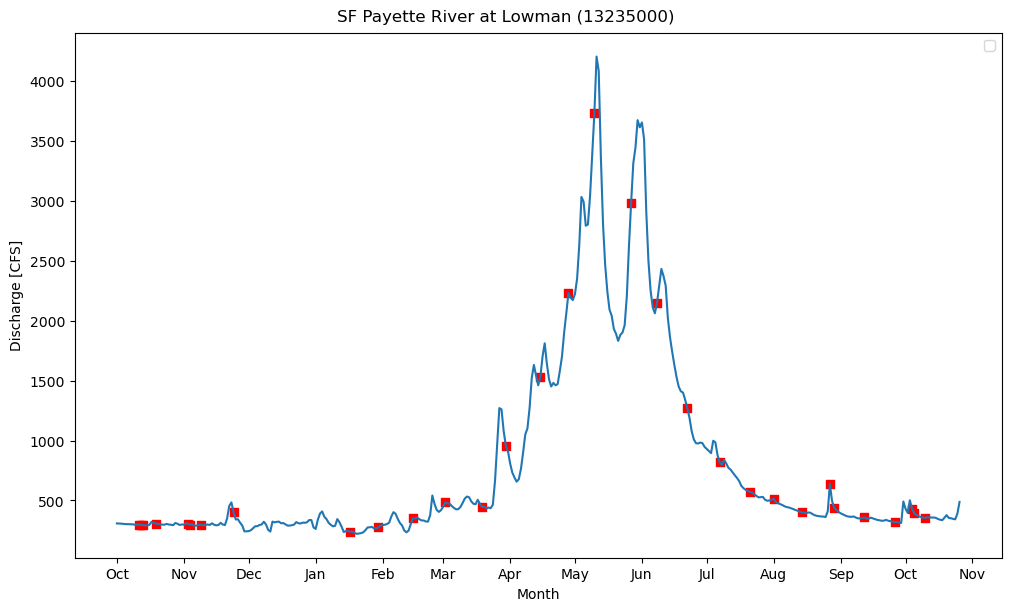

In [47]:
# subplot with TSS concentrations on inset figure or seperate axis
fig, ax = plt.subplots(figsize=(10,6), layout='constrained')
ax.scatter(df2.index, df2.q_cfs, marker='s', color='red')
ax.plot(wy2_streamflow.date, wy2_streamflow.q_cfs)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_xlabel('Month')
ax.set_ylabel('Discharge [CFS]')
handles, labels = ax.get_legend_handles_labels()
plt.suptitle(f"{gage_names[3]} ({my_gage})")
ax.legend(handles, labels)

plt.show()


In [11]:
df2.describe()

,q_cfs
count,31.000000
mean,786.612903
std,861.698736
min,240.000000
25%,306.500000
50%,402.000000
75%,727.000000
max,3730.000000


In [12]:
# This is not D.R.Y. - refactor to streamline datetime handling?
dt_output = df2.index
q_output = df2['q_cfs']
sample_dict = {
    'date': dt_output.strftime('%Y-%m-%d'),
    'q_cfs': q_output
}
sample_df = pd.DataFrame(sample_dict)

In [13]:
def get_density_functions(data:"pd.DataFrame"):
    """
    Calculates probability density and cumulative density functions for daily mean streamflow values.
    

    Params
    --------
        data (DataFrame): a pandas DataFrame object with a field named q_cfs.
    
    Returns
    --------
        wy_stats (dict): a dictionary of np.arrays. 
    
    """
    wy_bins = np.linspace(data.iloc[:,1].min(), data.iloc[:,1].max(), len(data.iloc[:,1]), endpoint=False)
    pdf, binedges = np.histogram(data.iloc[:,1], bins=wy_bins, density=True)
    cdf = np.cumsum(pdf * np.diff(wy_bins))
    wy_p = np.percentile(sorted(wy_bins), [5, 50, 95])

    wy_stats = {
        "bins": wy_bins,
        "bin_edges": binedges,
        "pdf": pdf,
        "cdf": cdf,
        "percentiles": wy_p
    }
    return wy_stats

In [14]:
sampling_stats = get_density_functions(sample_df)
wy2 = get_density_functions(wy2_streamflow)

In [17]:
def plot_streamflow_pdf(wy1, wy2):
    """
    Plots a probability density function for two water years.

    Params
    --------
        wy1, wy2 (DataFrame): a pandas DataFrame with values compiled from the function Get_StreamFlowData.
    
    Returns
    --------
        none, displays side-by-side plots
    
    """
    
    fig, (ax1, ax2) = plt.subplots(1,2,sharex=False, figsize=(10,4))
    ax1.hist(wy1.iloc[:,1], bins='auto', density=False, color='b', label='Sample dates only')
    ax2.hist(wy2.iloc[:,1], bins='auto', density=False, color='g', label='WY2025+')

    #ax1.set_xlabel('Dishcarge [cms]')
    ax2.set_xlabel('Dishcarge [cms]')

    ax1.set_ylabel('Frequency')


    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    plt.suptitle(f"{gage_names[3]} ({my_gage})")
    fig.legend(handles1 + handles2, labels1 + labels2, loc='lower center', ncol=2)

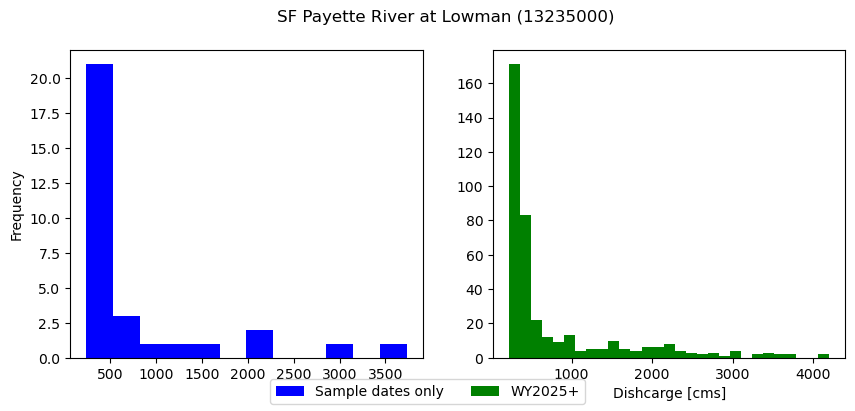

In [18]:
# Not sure if the density part is right, refactor the plot_pdf function to not use plt.hist. Just plot the np.hist as bar graph with adjusted bar widths
# play with the bin edges to identify more sampling gaps within the lower flow ranges?
plot_streamflow_pdf(wy1=sample_df, wy2=wy2_streamflow)

In [ ]:
# get both datasets into log-normal distribution mean and varience
# test the hypothesis does the sample data fit a log-normal distribution
# use KS test normal to run scenarios by increasing number of samples to see if it fits

In [ ]:
def plot_streamflow_cdf(wy1, wy2):
    """
    Plots a cumulative density function for two water years.
    Includes vertical lines that denote the 5-th, 50-th, and 95-th percentile values.

    Params
    --------
        wy1, wy2 (dict): a dictionary with values compiled from get_density_functions function
    
    Returns
    --------
        none, displays side-by-side plots
    
    """
    fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    # cumulative density plots
    ax3.plot(wy1['bins'][:-1], wy1['cdf'], color='C0', label='wy2024')
    ax4.plot(wy2['bins'][:-1], wy2['cdf'], color='C1', label='wy2025')

    ax3.vlines(wy1['percentiles'],0,1,transform=ax3.get_xaxis_transform(), linestyles="dashed", colors='k')
    ax3.set_xlabel('Discharge [cms]')
    ax4.vlines(wy2['percentiles'],0,1,transform=ax4.get_xaxis_transform(), linestyles="dashed", colors='k')
    ax4.set_xlabel('Discharge [cms]')
    ax3.grid(True, alpha=0.3)
    ax4.grid(True, alpha=0.3)
    
    fig2.text(0.065, 0.5, 'Percentile', va='center', rotation='vertical', fontsize=12)

    # Shared legend
    handles3, labels3 = ax3.get_legend_handles_labels()
    handles4, labels4 = ax4.get_legend_handles_labels()
    fig2.legend(handles3 + handles4, labels3 + labels4, loc='lower center', ncol=2)
    plt.suptitle(f"{gage_names[3]} ({my_gage})")

In [ ]:
plot_streamflow_cdf(wy1=wy1,wy2=wy2)

In [ ]:
np.cumsum() # Or x.cumsum(), where x is a vector of data
np.percentile() 
np.histogram() 
# Note: When using np.histogram(), make sure to use the same bins for both data records.
# Consider using min(), max(), and linspace() to create custom bins.

plt.hlines()
plt.vlines()

1. I looked up a different station. Replaced the last item in the my_gages list and added a new pair of start/end date variables identified with 3.
2. Potential error handling could include: 1. type checking the arguments in the function signature to ensure that strings are used. 2. Assert statements to check that data formatting is correct. 3. try/except statements to catch errors the nwis.get_dv() might encounter. For instance if the gage does not include obs from the specified time period. 4. checking that the streamgage identifier is valid and that the parameter code is valid.